epoch :0, batch :0, loss :[2.326334], accuracy :[0.06]
epoch :0, batch :200, loss :[1.6942463], accuracy :[0.78]
epoch :0, batch :400, loss :[1.6014245], accuracy :[0.87]
epoch :1, batch :0, loss :[1.5968703], accuracy :[0.87]
epoch :1, batch :200, loss :[1.6523213], accuracy :[0.81]
epoch :1, batch :400, loss :[1.5766824], accuracy :[0.88]
epoch :2, batch :0, loss :[1.580281], accuracy :[0.87]
epoch :2, batch :200, loss :[1.6259652], accuracy :[0.83]
epoch :2, batch :400, loss :[1.5682687], accuracy :[0.89]
epoch :3, batch :0, loss :[1.5775532], accuracy :[0.88]
epoch :3, batch :200, loss :[1.6229954], accuracy :[0.83]
epoch :3, batch :400, loss :[1.5684112], accuracy :[0.89]
epoch :4, batch :0, loss :[1.56896], accuracy :[0.89]
epoch :4, batch :200, loss :[1.6151911], accuracy :[0.84]
epoch :4, batch :400, loss :[1.4885594], accuracy :[0.97]
epoch :5, batch :0, loss :[1.4852649], accuracy :[0.97]
epoch :5, batch :200, loss :[1.5231993], accuracy :[0.94]
epoch :5, batch :400, loss :[1

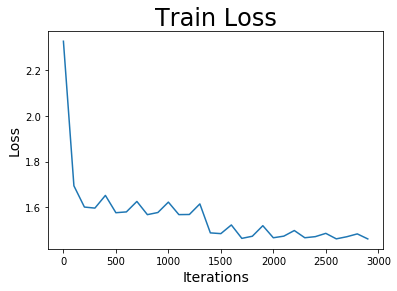

start evaluation......
loss :1.4810793030261993, accuracy :0.9812000060081482


In [8]:
import os
import random
import paddle
import numpy as np 
from PIL import Image
import gzip
import  json


def load_data(mode='train'):
    datafile='./work/mnist.json.gz'
    data=json.load(gzip.open(datafile))
    train_set,val_set,eval_set=data
    #shape of the images
    IMG_ROWS=28
    IMG_CLOS=28
    #load data based on the mode
    if mode=='train':
        imgs=train_set[0]
        labels=train_set[1]
    elif mode=='valid':
        imgs=val_set[0]
        labels=val_set[1]
    elif mode=='eval':
        imgs=eval_set[0]
        labels=eval_set[1]

    imgs_len=len(imgs)
    assert len(imgs)==len(labels),            "length of the images({}) should be the same as labels({})".format(len(imgs),len(labels))
    index_list=list(range(imgs_len))

    BATCH_SIZE=100

    def data_generator():
        if mode==train:
            random.shuffle(index_list)
        imgs_list=[]
        labels_list=[]
        for i in index_list:
            img=np.reshape(imgs[i],[1,IMG_ROWS,IMG_CLOS]).astype('float32')
            label=np.reshape(labels[i],[1]).astype('int64')
            imgs_list.append(img)
            labels_list.append(label)
            if len(imgs_list)==BATCH_SIZE:
                yield np.array(imgs_list),np.array(labels_list)
                imgs_list=[]
                labels_list=[]
        if len(imgs_list)>0:
            yield np.array(imgs_list),np.array(labels_list)
    return data_generator


import paddle.nn.functional as F 
from paddle.nn import Conv2D,MaxPool2D,Linear

class Net(paddle.nn.Layer):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=Conv2D(1,6,5,1,2)
        self.conv2=Conv2D(6,16,5)
        self.pool1=MaxPool2D(kernel_size=2,stride=2)
        self.pool2=MaxPool2D(kernel_size=2,stride=2)
        self.fc=Linear(in_features=16*5*5,out_features=10)
    def forward(self,inputs,label):
        x=self.conv1(inputs)
        x=F.relu(x)
        x=self.pool1(x)
        x=self.conv2(x)
        x=F.relu(x)
        x=self.pool2(x)
        x=paddle.reshape(x,[x.shape[0],16*5*5])
        x=self.fc(x)
        x=F.softmax(x)
        if label is not None:
            acc=paddle.metric.accuracy(input=x,label=label)
            return x,acc
        else:
            return x



train_loader=load_data('train')
use_gpu=True
paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')


def train(model):
    model=Net()
    model.train()
    optim=paddle.optimizer.Adam(learning_rate=0.001,weight_decay=paddle.regularizer.L2Decay(coeff=1e-5),parameters=model.parameters())

    EPOCH_NUM=10

    losses=[]
    iters=[]
    iter=0
    for epoch in range(EPOCH_NUM):
        for batch,data in enumerate(train_loader()):
            images,labels=data
            images=paddle.to_tensor(images)
            labels=paddle.to_tensor(labels)

            pred,acc=model(images,labels)
            loss=F.cross_entropy(pred,labels)
            avg_loss=paddle.mean(loss)

            if batch%200==0:
                print("epoch :{}, batch :{}, loss :{}, accuracy :{}".format(epoch,batch,avg_loss.numpy(),acc.numpy()))
                losses.append(avg_loss.numpy()[0])
                iters.append(iter)
                iter+=100
            avg_loss.backward()
            optim.step()
            optim.clear_grad()
    paddle.save(model.state_dict(),'net.pdparams')
    return iters,losses

model=Net()
iters,losses=train(model)


import matplotlib.pyplot as plt
plt.title('Train Loss',fontsize=24)
plt.xlabel('Iterations',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.plot(iters,losses)
plt.show()


def evaluation(model):
    print('start evaluation......')
    params_file_path='net.pdparams'
    params_dict=paddle.load(params_file_path)
    model.load_dict(params_dict)

    model.eval()
    eval_loader=load_data('eval')

    acc_set=[]
    avg_loss_set=[]
    for batch,data in enumerate(eval_loader()):
        images,labels=data
        images=paddle.to_tensor(images)
        labels=paddle.to_tensor(labels)
        pred,acc=model(images,labels)
        loss=F.cross_entropy(pred,labels)
        avg_loss=paddle.mean(loss)
        avg_loss_set.append(float(avg_loss.numpy()))
        acc_set.append(float(acc.numpy()))

    acc_val_mean=np.array(acc_set).mean()
    avg_loss_val_mean=np.array(avg_loss_set).mean()

    print("loss :{}, accuracy :{}".format(avg_loss_val_mean,acc_val_mean))

model=Net()
evaluation(model)